In [1]:
import numpy as np
from tqdm import tqdm
import timeit
from matplotlib import pyplot as plt

import mala
from scipy.integrate import nquad

In [2]:
dim = 1
h = 0.2
n = 2000
N_train = 100
N_test = 50

def f(x):
    a = 1 / np.sqrt(2)
    return 1/2 * (x-a)**2 - np.log(1 + np.exp(-2 * x * a))

def f_grad(x):
    a = 1 / np.sqrt(2)
    return x - a + 2 * a/(1 + np.exp(2* (x * a)))

def pi(x):
    a = 1 / np.sqrt(2)
    return 1/(2 * (2 * np.pi)**(dim/2)) * (np.exp(-(x-a)**2 /2) + np.exp(-(x+a)**2 / 2))


def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [3]:
def ULA_with_burnin(d, step, burn_in, n, f_grad):
    """ MCMC ULA
    Args:
        Md: dimension
        step: stepsize of the algorithm
        burn_in: burn-in period
        n: number of samples after the burn-in
        f_grad: gradient of the potential U
    Returns:
        traj: a numpy array of size (n, d), where the trajectory is stored
        traj_grad: numpy array of size (n, d), where the gradients of the potential U along the trajectory are stored
        traj_noise: numpy array of size (n, d), where the noises along trajectory are stored
    """
    traj = np.zeros((burn_in + n, d))
    traj_grad = np.zeros((burn_in + n, d))
    traj_noise = np.random.randn(burn_in + n, d)
    
    traj[0] = (np.random.normal(0,1,d)).reshape(d)
    traj_grad[0] = f_grad(traj[0])

    for i in range(1,burn_in + n):
        traj[i] = traj[i-1] - step/2*traj_grad[i-1] + np.sqrt(step) * traj_noise[i]
        traj_grad[i] = f_grad(traj[i])
    return traj[burn_in:], traj_grad[burn_in:], traj_noise[burn_in:]

In [4]:
np.random.seed(42)
X_ULA, _, _  = ULA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad)
X, G, Z , U, ac_rate = mala.MALA_with_burnin(d=dim, step=h, burn_in=20000, n=100000,f_grad = f_grad, f = f)

0.99492


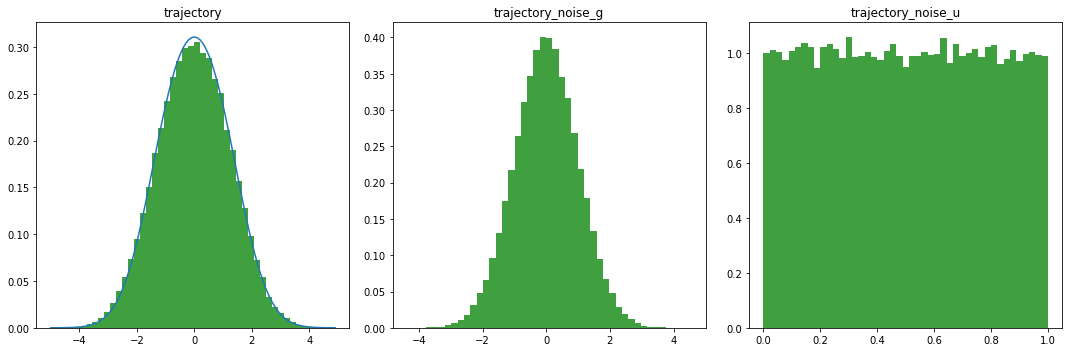

In [5]:
print (ac_rate)
mala.plot_distr(X, Z, U, 0, pi)

In [6]:
np.random.seed(123)

XX, GG, ZZ, UU = mala.generate_train_trajectories(X, N_train=N_train,d = dim, step = h, n = n, f_grad=f_grad, f = f)
XX_test, GG_test, ZZ_test, UU_test = mala.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad, f = f)

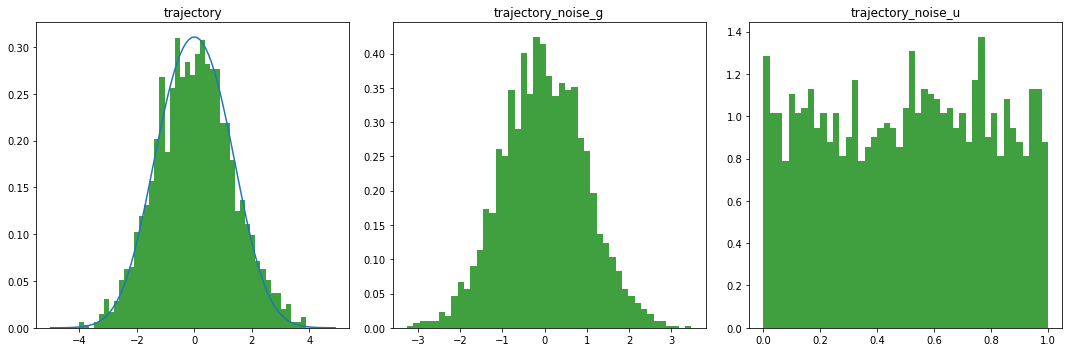

In [7]:
mala.plot_distr(XX[2], ZZ[0], UU[0], 0, pi)

In [8]:
def H(k, x): #Hermite
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    h = hermitenorm(k)(x) /  np.sqrt(math.factorial(k))
    return h

def L(k,x): #Shifted Legandre 
    if k==0:
        return 1.
    elif k==1:
        return np.sqrt(3) * (2*x - 1)
    elif k ==2:
        return np.sqrt(5) * (6*x**2 - 6*x +1)
    else:
        return None
    
def Hermite_val(k_vec,x_vec):
    P = 1.0
    d = x_vec.shape[0]
    for i in range(d):
        P = P * H(k_vec[i],x_vec[i])
    return P

def phi_val(k_vec, x_vec, uni):
    return H(k_vec[:-1], x_vec) * L(k_vec[-1], uni)

### Check orthonormality

In [9]:
def check_exp_leg(k_1, k_2, n=2000000):
    xi = np.random.uniform(size=n)
    s = np.zeros_like(xi)
    for i in range(n):
        s[i] = L(k_1, xi[i]) * L(k_2, xi[i])
    return s.mean()

def check_exp_hermite(k_1, k_2, n=2000000):
    xi = np.random.randn(n)
    s = np.zeros_like(xi)
    for i in range(n):
        s[i] = H(k_1, xi[i]) * H(k_2, xi[i])
    return s.mean()

### Approximate $Q_{p,l}$

In [10]:
def generate_X_poly(train_traj, l, max_deg):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    d = train_traj.shape[2]
    poly = PolynomialFeatures(max_deg)
    X = poly.fit_transform(train_traj[:, l])
    return X, poly.powers_

def generate_y_sum(train_traj, l, f_target, n_tilde):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    d = train_traj.shape[2]
    y = np.zeros(N_train)
    for s in range(N_train):
        if f_target == "sum":
            y[s] = train_traj[s,l:].sum()/N
            # y[s] = train_traj[s,l:l+n_tilde].sum()/N
        elif f_target == "sum_squared":
            y[s] = np.square(train_traj[s, l:]).sum()/N
        elif f_target == "sum_4th":
            y[s] = (train_traj[s,l:]**4).sum()/N
        elif f_target == "exp_sum":
            y[s] = np.exp(train_traj[s, l:].sum(axis =1)).sum()/N
        else:
            raise Exception('unrecognized target function')
    return y

def Q_l_fit(train_traj, f_target="sum", max_deg = 1, n_tilde = 100):
    N_train = train_traj.shape[0]
    N = train_traj.shape[1]
    d = train_traj.shape[2]
    Betas = np.zeros((N, d+ 1 + (max_deg-1) * int(d*(d+1)/2)))
    for l in tqdm(range(N)):
        # Linear Regression
        if 0 < max_deg < 6:
            X, degrees = generate_X_poly(train_traj, l, max_deg)
        else:
            raise Exception('max_deg should be 1 or 2')
        y = generate_y_sum(train_traj, l, f_target, n_tilde)

        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[l] = beta
    return Betas, degrees

def Q_l_predict(x, l, Betas, max_deg = 1):
    poly = PolynomialFeatures(max_deg)
    x_pol = poly.fit_transform(x.reshape(1,-1))
    beta = Betas[l]
    return (x_pol @ beta)

### Compute 

### $a_{l,k_1, k_2}(x) = \mathbb{E}_{u, \xi} \left[ H_{k_1}(\xi) L_{k_2}(u) Q_{l}\left( x + \mathbb{1}\left\{u \leq \alpha(x, x - \gamma \mu(x) + \sqrt{\gamma} \xi) \right\}(-\gamma \mu(x) + \sqrt{\gamma}\xi) \right)\right] = \\
=  \int_0^1 \int_{-\infty}^{\infty} H_{k_1}(\xi) L_{k_2}(u) Q_{l} \left( x + \mathbb{1}\left\{u \leq \alpha(x, x - \gamma \mu(x) + \sqrt{\gamma} \xi) \right\}(-\gamma \mu(x) + \sqrt{\gamma}\xi) \right) \varphi(\xi) d\xi du$

In [41]:
from scipy.integrate import nquad
from scipy.stats import norm

def integrand(ksi, u, k_vec, x, x_grad, l):# x - gaussian, y - uniform
    point = x
    next_point = np.array([x - h/2 * x_grad + np.sqrt(h) * ksi])
    logratio = -f(next_point)+f(x) + (1./(2*h))*(np.linalg.norm(next_point-x+h/2*x_grad)**2 \
                      - np.linalg.norm(x-next_point+h/2*f_grad(next_point))**2)
    if np.log(u)<=logratio:
         point = next_point
    return Q_l_predict(point, l, Betas) * phi_val(k_vec, ksi, u)* norm.pdf(ksi)

def bounds_u(k_vec, x, x_grad, l):
    return (0,1)

def bounds_ksi(u, k_vec, x, x_grad, l):
    return (-3, 3)

options_ksi = {'limit':100}
options_u = {'limit':50}
def a_lk_explicit(k_vec, x, x_grad, l):
    return nquad(integrand, ranges = [bounds_ksi, bounds_u], args = (k_vec, x,x_grad, l), opts=[options_ksi,options_u])[0]

In [42]:
def a_lk_explicit_2(k_vec, x, x_grad, l):
    ksi = np.random.randn(500)
    u = np.random.uniform(size=ksi.shape[0])
    s = np.empty_like(ksi)
    for i in range(ksi.shape[0]):
        point = x
        next_point = np.array([x - h/2 * x_grad + np.sqrt(h) * ksi[i]])
        logratio = -f(next_point)+f(x) + (1./(2*h))*(np.linalg.norm(next_point-x+h/2*x_grad)**2 \
                          - np.linalg.norm(x-next_point+h/2*f_grad(next_point))**2)
        if np.log(u[i])<=logratio:
             point = next_point
        s[i] = Q_l_predict(point, l, Betas) * phi_val(k_vec, ksi[i], u[i])
    return s.mean()

In [ ]:
a_lk_explicit(k_comb[0], XX[5, 5], GG[5,5], 5)

In [ ]:
a_lk_explicit_2(k_comb[0], XX[5, 5], GG[5,5], 5)

In [18]:
def M_bias(k_vec, traj, traj_grad, traj_noise_g, traj_noise_u, step, degrees, Betas):
    N = traj.shape[0]
    S = 0
    for l in range (N):
        s = a_lk_explicit_2(k_vec, traj[l-1],traj_grad[l-1],l)* phi_val(k_vec,traj_noise_g[l], traj_noise_u[l])
        S = S + s
    return S

def estimator_bias(k_vec, test_traj, test_traj_grad, test_traj_noise_g, test_traj_noise_u, 
                   step, degrees, Betas, n_tilde, n_jobs = -1):
    N_test = test_traj.shape[0]
    M_results = Parallel(n_jobs = n_jobs)(delayed(M_bias)(k_vec, test_traj[i], test_traj_grad[i], test_traj_noise_g[i],
                                                          test_traj_noise_u[i], step, degrees, Betas)
                                          for i in range(N_test))
    return np.array(M_results).reshape(-1)

In [14]:
import numpy as np
from scipy.special import comb
from scipy.special import hermitenorm
from tqdm import tqdm
from joblib import Parallel, delayed
from itertools import product
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import math
import ZVnbrosse

In [15]:
f_target = 'sum'
deg = 1
Betas, degrees = Q_l_fit(XX,f_target, max_deg = deg)

100%|██████████| 2000/2000 [00:01<00:00, 1385.95it/s]


In [16]:
k_comb = np.zeros((dim + 1,dim + 1), dtype = np.int16)
for i in range(dim+1):
    k_comb[i,i] = 1

In [22]:
i_test = 8
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - M_bias(k_comb[i], XX_test[i_test],GG_test[i_test], ZZ_test[i_test],UU_test[i_test], h, degrees,Betas)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = 0.12432502570971457
            (k = [1 0]) = [0.06694022] [Time:153.2925729099661]
            (k = [0 1]) = [0.04924648] [Time:308.1332435850054]


In [24]:
i_test = 0
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - M_bias(k_comb[i], XX_test[i_test],GG_test[i_test], ZZ_test[i_test],UU_test[i_test], h, degrees,Betas)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = 0.1867189387274775
            (k = [1 0]) = [0.03281828] [Time:254.38500311900862]
            (k = [0 1]) = [0.05263501] [Time:592.7688449299894]


In [26]:
i_test = 25
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - M_bias(k_comb[i], XX_test[i_test],GG_test[i_test], ZZ_test[i_test],UU_test[i_test], h, degrees,Betas)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = 0.20655294878462957
            (k = [1 0]) = [0.01463958] [Time:325.3491010069847]
            (k = [0 1]) = [0.02230949] [Time:645.6017091129906]


In [27]:
i_test = 24
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
for i in range(len(k_comb)):
    p = p - M_bias(k_comb[i], XX_test[i_test],GG_test[i_test], ZZ_test[i_test],UU_test[i_test], h, degrees,Betas)
    print ("            (k = {}) = {} [Time:{}]".format(k_comb[i],p,timeit.default_timer()-time_1))

mean of target function = -0.04963849326128689
            (k = [1 0]) = [0.06905181] [Time:339.8777641709894]
            (k = [0 1]) = [0.05700757] [Time:688.7560711189872]


In [28]:
P_test = estimator(XX_test)

100%|██████████| 30/30 [00:00<00:00, 2232.28it/s]


In [29]:
M_test = np.empty((len(k_comb),P_test.shape[0]))
for i in range(len(k_comb)):
    M_test[i] = estimator_bias(k_comb[i],XX_test, GG_test, ZZ_test,UU_test, h, degrees,Betas,100, n_jobs=-1)

In [31]:
def ZVpolyOne(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    cov1 = np.var(traj_grad)
    A = 1 / cov1
    covariance = np.cov(np.concatenate((-traj_grad, samples), axis=1), rowvar=False)
    paramZV1 = -np.dot(A,covariance[:d, d:])
    ZV1 = samples - np.dot(traj_grad, paramZV1)
    mean_ZV1 = np.mean(ZV1, axis = 0)
    return mean_ZV1

res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), f_target))
res_cv_2 = np.array(res_cv_2).reshape(-1)

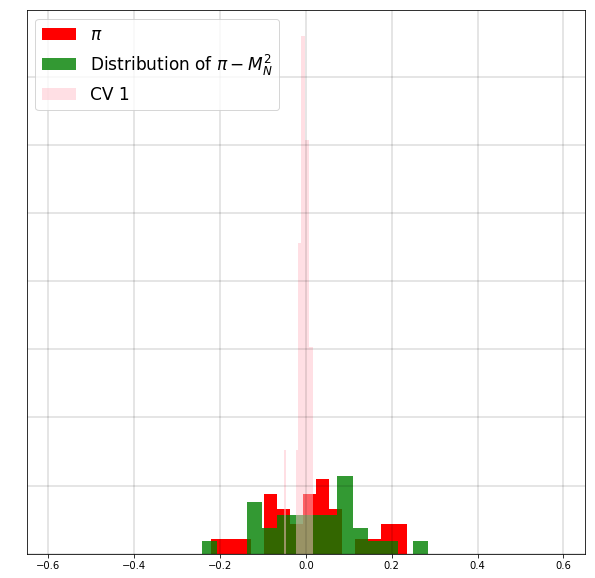

In [32]:
plt.figure(figsize=(10,10))
plt.hist(P_test,15, facecolor='r', density=True, alpha=1, label=r"$\pi$")

plt.hist((P_test-M_test.sum(axis=0)),15, density=True, facecolor='g', alpha=0.8, label="Distribution of $\pi - M^2_N$")
# 
# plt.hist(res_zv_1,15, facecolor='y', density=True, alpha=0.5, label="ZV 1")
# plt.hist(res_zv_2,15, facecolor='b', density=True, alpha=0.5, label="ZV 2")
plt.hist(res_cv_1,15, facecolor='pink', density=True, alpha=0.5, label="CV 1")
# plt.hist(res_cv_2,15, facecolor='black', density=True, alpha=0.5, label="CV 2")

plt.legend(loc=2, prop={'size': 17})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.tick_params(axis='y',color = 'w', labelcolor = 'w', which='both')
plt.xlim(-0.65, 0.65)
plt.show()

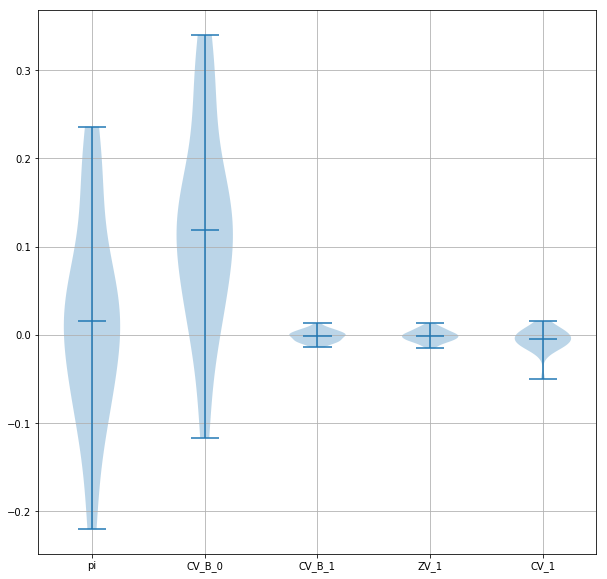

In [40]:
all_data = [P_test]
all_data.append(P_test - M_test[0].sum(axis = 0))
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
# all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
# plt.title('violin plot')
plt.xticks(np.arange(1,6), ('pi', 'CV_B_0', 'CV_B_1','ZV_1', 'CV_1'))
plt.grid()
plt.show()

In [151]:
print ('          Variance of Pi = ',P_test.var(ddof = 1))
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test_0[:i+1].sum(axis = 0)).var(ddof = 1))
    
for i in range(len(k_comb)):
    print ('Variance of new estimator =',(P_test-M_test_0.sum(axis = 0) - M_test_1[:i+1].sum(axis=0)).var(ddof = 1))    
print ('        Variance of CV 1 = ',res_cv_1.var(ddof=1))
print ('        Variance of CV 2 = ',res_cv_2.var(ddof=1))
print ('        Variance of ZV 1 = ',res_zv_1.var(ddof=1))
print ('        Variance of ZV 2 = ',res_zv_2.var(ddof=1))

          Variance of Pi =  0.0469585202996712
Variance of new estimator = 0.025332211551711174
Variance of new estimator = 0.0035485609448273592
Variance of new estimator = 0.016342502489807748
Variance of new estimator = 0.026294280267076225
        Variance of CV 1 =  0.0015398600470525171
        Variance of CV 2 =  0.00018066699411613726
        Variance of ZV 1 =  0.00016601313130501939
        Variance of ZV 2 =  0.00018263035353649048


In [38]:
P_test

array([ 0.18671894, -0.22017982,  0.05172159,  0.01836287,  0.03852246,
       -0.08944497, -0.13346078, -0.09787203,  0.12432503, -0.02008763,
       -0.05280298,  0.03031612,  0.07392707,  0.05908892, -0.0848727 ,
       -0.01263467, -0.00341095,  0.18431554,  0.23607057, -0.03872013,
       -0.07192854, -0.18587785,  0.15056888,  0.07929719, -0.04963849,
        0.20655295,  0.02041022,  0.01584186,  0.02555573,  0.02527972])

In [39]:
M_test

array([[ 0.12958964, -0.12726368, -0.03308238,  0.11095279, -0.27188782,
        -0.21094805, -0.0385241 , -0.18132999,  0.06632507, -0.08016251,
        -0.13552428,  0.09158977, -0.00444678, -0.06031706, -0.10729474,
        -0.08619773, -0.00818646,  0.15486799,  0.19256498,  0.05933327,
        -0.22122872, -0.09925785,  0.02747529, -0.09917067, -0.07834365,
         0.20148763,  0.13492664,  0.25917328,  0.14305807,  0.16805124],
       [ 0.0025138 , -0.02979296,  0.029601  ,  0.01703631,  0.02665195,
         0.01313974,  0.03072679,  0.00644165, -0.01929455, -0.01532734,
        -0.01366044,  0.00260752,  0.013596  , -0.01266224, -0.00882351,
        -0.01098121,  0.0277791 ,  0.03097747,  0.02534726, -0.04099477,
        -0.00168138, -0.00577097, -0.01264861, -0.01235804,  0.01471593,
         0.01265929, -0.01619072, -0.00135336,  0.00334243, -0.01368109]])

In [34]:
P_test - M_test.sum(axis = 0)

array([-0.0429549 ,  0.1932544 , -0.07801865,  0.11277088,  0.13288961,
       -0.17920246,  0.11902433,  0.00202884,  0.03348633,  0.25132799,
       -0.10545572,  0.17410216,  0.19374052,  0.17103535,  0.06830751,
        0.00336771,  0.0950076 ,  0.262882  ,  0.00135742,  0.15078327,
        0.02943799, -0.32331426,  0.02750302,  0.09583629, -0.08452184,
        0.21500967,  0.01380431, -0.0051356 ,  0.10196652, -0.04038207])